In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# --- 1) Imports: basic utilities, image processing, ML libraries ---
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [3]:
# --- 2) Check GPU availability (very important for training speed on Kaggle) ---
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPU memory growth set.')
    except Exception as e:
        print('Could not set memory growth:', e)

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth set.


In [4]:
# --- 3) Dataset paths (Kaggle) ---
BASE_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

print('Train contains:', os.listdir(train_dir)[:10])
print('Val contains:', os.listdir(val_dir)[:10])
print('Test contains:', os.listdir(test_dir)[:10])

def count_images(dir_path):
    counts = {}
    for cls in os.listdir(dir_path):
        cls_path = os.path.join(dir_path, cls)
        counts[cls] = len(os.listdir(cls_path))
    return counts

print('\nTrain counts:', count_images(train_dir))
print('Val counts:  ', count_images(val_dir))
print('Test counts: ', count_images(test_dir))

Train contains: ['PNEUMONIA', 'NORMAL']
Val contains: ['PNEUMONIA', 'NORMAL']
Test contains: ['PNEUMONIA', 'NORMAL']

Train counts: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Val counts:   {'PNEUMONIA': 8, 'NORMAL': 8}
Test counts:  {'PNEUMONIA': 390, 'NORMAL': 234}


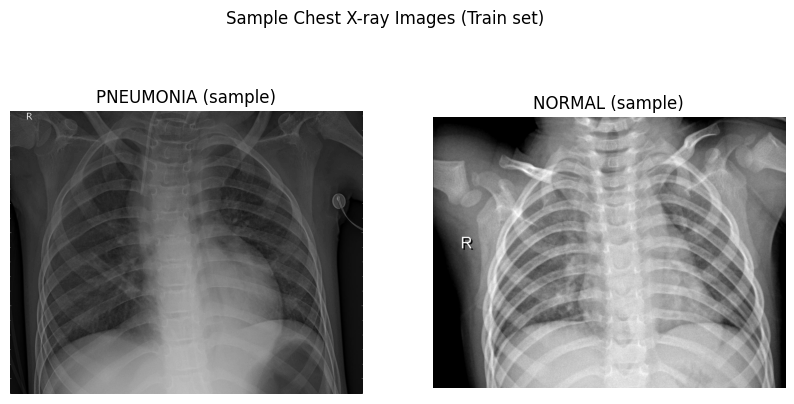

In [5]:
# --- 4) Visualize sample images (helps understand input data) ---
plt.figure(figsize=(10,5))
categories = ['PNEUMONIA', 'NORMAL']

for i, cat in enumerate(categories):
    folder = os.path.join(train_dir, cat)
    sample_img = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, sample_img)
    img = imread(img_path)
    plt.subplot(1,2,i+1)
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(f"{cat} (sample)")
    plt.axis('off')
plt.suptitle('Sample Chest X-ray Images (Train set)')
plt.show()

In [6]:
# --- 5) Data augmentation & generators ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
print('Class indices:', class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [7]:
# --- 6) Build the model using VGG19 as base (transfer learning) ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='dropout1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
preds = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.summary()

I0000 00:00:1761846178.511954      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             

 Total params: 24,285,122 (92.64 MB)

 Trainable params: 4,260,738 (16.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
# --- 7) Compile model and set up callbacks ---
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
lr_plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
checkpoint_path = '/kaggle/working/best_vgg19_pneumonia.h5'
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [es, lr_plateau, mc]

In [9]:
# --- 8) Train the model (initial training with frozen base) ---
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/kaggle/working/training_history_initial.csv', index=False)
print('Training history saved.')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1761846237.171520     125 service.cc:148] XLA service 0x7cccd0010380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761846237.172256     125 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761846237.692424     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/163 ━━━━━━━━━━━━━━━━━━━━ 20:52 8s/step - accuracy: 0.2500 - loss: 1.2164

I0000 00:00:1761846242.214288     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7870 - loss: 0.4611
Epoch 1: val_loss improved from inf to 0.44888, saving model to /kaggle/working/best_vgg19_pneumonia.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 559ms/step - accuracy: 0.7873 - loss: 0.4605 - val_accuracy: 0.8125 - val_loss: 0.4489 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8955 - loss: 0.2483
Epoch 2: val_loss did not improve from 0.44888
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 361ms/step - accuracy: 0.8955 - loss: 0.2482 - val_accuracy: 0.8125 - val_loss: 0.5527 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9144 - loss: 0.2099
Epoch 3: val_loss did not improve from 0.44888
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 359ms/step - accuracy: 0.9144 - loss: 0.2099 - val_accuracy: 0.8125 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9236 - loss: 0.1875
Epoch 4: ReduceLR

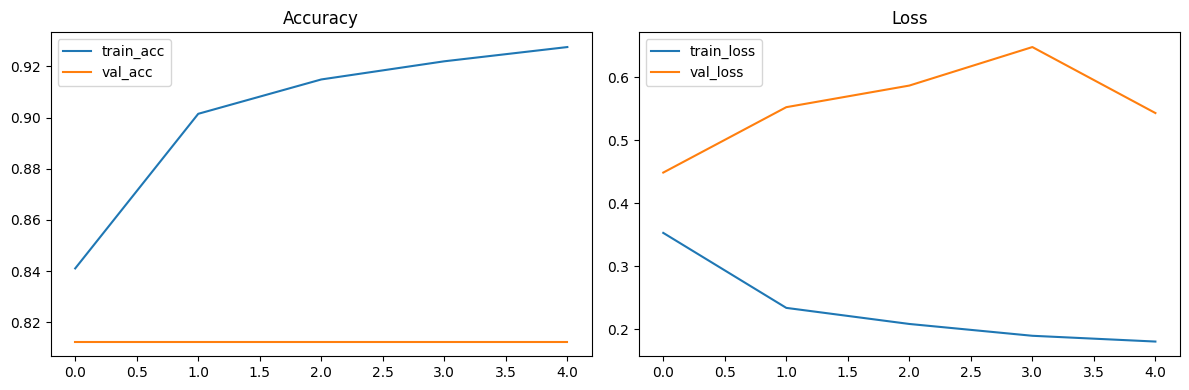

In [10]:
# --- 9) Plot accuracy & loss curves ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Loaded best weights from checkpoint.
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.7630 - loss: 0.5165
Test loss: 0.3575 | Test accuracy: 0.8429
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.89      0.66      0.76       234
   PNEUMONIA       0.82      0.95      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.81      0.82       624
weighted avg       0.85      0.84      0.84       624



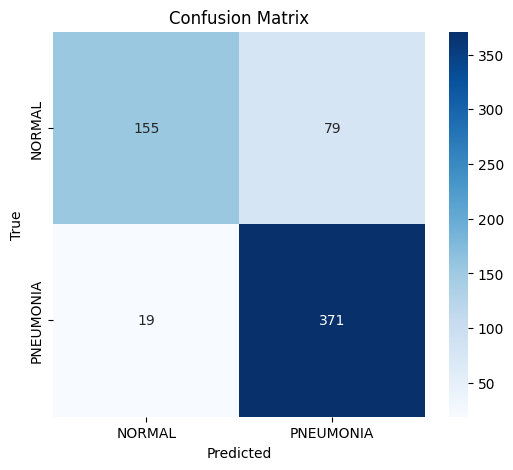

In [11]:
# --- 10) Evaluate on the test set & print classification report ---
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print('Loaded best weights from checkpoint.')

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print('\nClassification Report:\n')
print(classification_report(true_labels, pred_labels, target_names=class_names))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# --- 11) Fine-tuning: unfreeze last VGG blocks and train with a lower LR ---
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

FT_EPOCHS = 10
fine_tune_history = model.fit(
    train_generator,
    epochs=FT_EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

ft_hist_df = pd.DataFrame(fine_tune_history.history)
ft_hist_df.to_csv('/kaggle/working/training_history_finetune.csv', index=False)
print('Fine-tune history saved.')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             

 Total params: 24,285,122 (92.64 MB)

 Trainable params: 13,699,970 (52.26 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9090 - loss: 0.2104
Epoch 1: val_loss improved from 0.44888 to 0.42422, saving model to /kaggle/working/best_vgg19_pneumonia.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 404ms/step - accuracy: 0.9091 - loss: 0.2102 - val_accuracy: 0.8125 - val_loss: 0.4242 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9397 - loss: 0.1651
Epoch 2: val_loss improved from 0.42422 to 0.36497, saving model to /kaggle/working/best_vgg19_pneumonia.h5
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 370ms/step - accuracy: 0.9397 - loss: 0.1651 - val_accuracy: 0.8125 - val_loss: 0.3650 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9483 - loss: 0.1349
Epoch 3: val_loss did not improve from 0.36497
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 360ms/step - accuracy: 0.9483 - loss: 0.1349 - val_accuracy: 0.8750 - val_loss: 0.3764 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━

Loaded best weights from checkpoint.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.8952 - loss: 0.3520
Final Test loss: 0.2557 | Final Test accuracy: 0.9167
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step


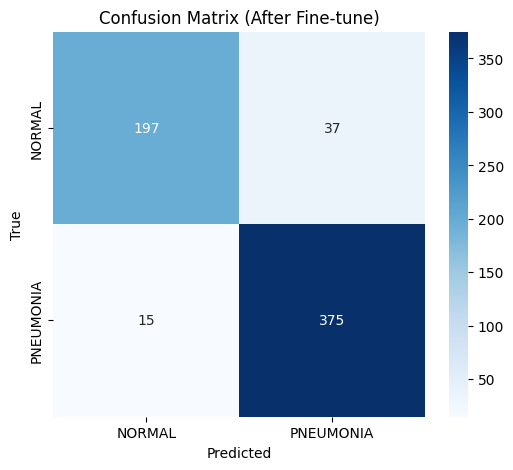

In [13]:
# --- 12) Evaluate after fine-tuning ---
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print('Loaded best weights from checkpoint.')

test_loss, test_acc = model.evaluate(test_generator)
print(f'Final Test loss: {test_loss:.4f} | Final Test accuracy: {test_acc:.4f}')

pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
cm = confusion_matrix(test_generator.classes, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (After Fine-tune)')
plt.show()

In [14]:
# --- 13) Save the final model to /kaggle/working (you can download this from Kaggle) ---
final_model_path = '/kaggle/working/final_vgg19_pneumonia.h5'
model.save(final_model_path)
print('Final model saved to:', final_model_path)

Final model saved to: /kaggle/working/final_vgg19_pneumonia.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


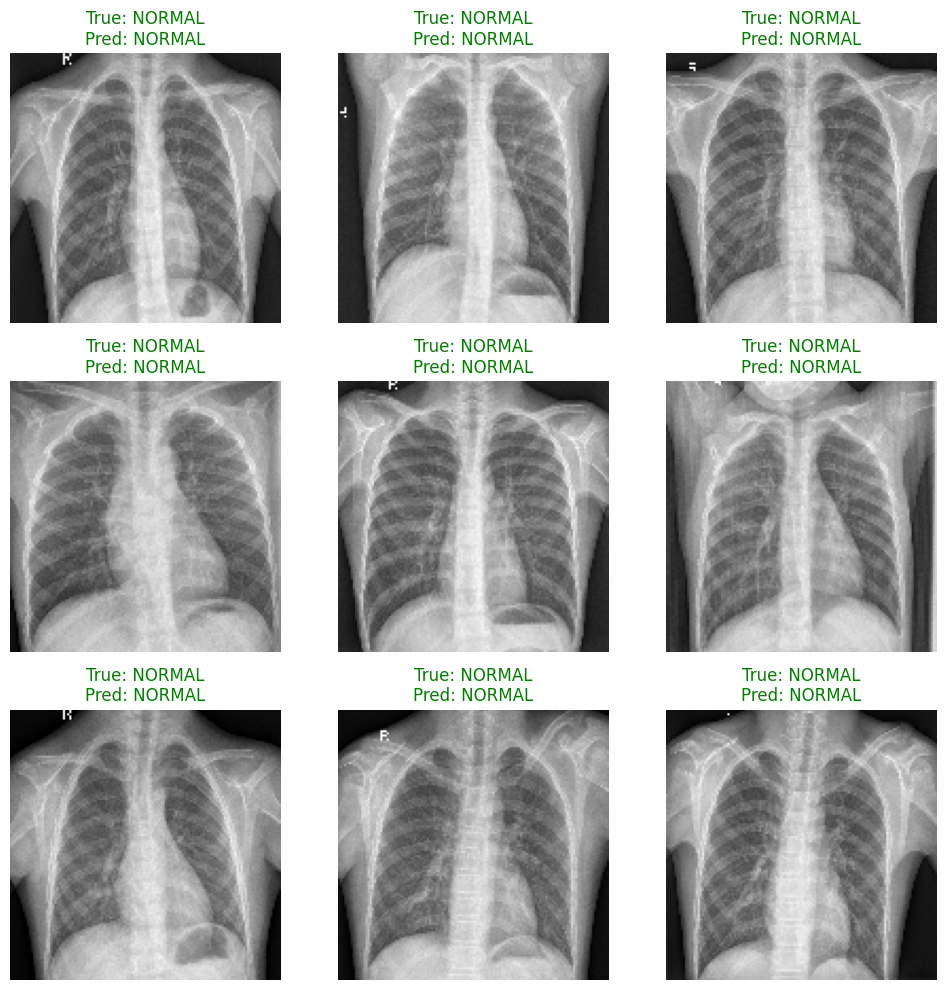

In [15]:
# --- 14) Visualize sample predictions on a batch from test set ---
x_batch, y_batch = next(test_generator)
preds = model.predict(x_batch)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = x_batch[i]
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img)
    true_label = class_names[np.argmax(y_batch[i])]
    pred_label = class_names[np.argmax(preds[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
import os

# List all files saved in /kaggle/working
for root, dirs, files in os.walk('/kaggle/working'):
    for f in files:
        print(os.path.join(root, f))


/kaggle/working/training_history_finetune.csv
/kaggle/working/training_history_initial.csv
/kaggle/working/final_vgg19_pneumonia.h5
/kaggle/working/best_vgg19_pneumonia.h5


In [ ]:
from zipfile import ZipFile
import os

# Paths of both models
final_model_path = "/kaggle/working/final_vgg19_pneumonia.h5"
best_model_path = "/kaggle/working/best_vgg19_pneumonia.h5"

# Zip the final model
if os.path.exists(final_model_path):
    with ZipFile("/kaggle/working/final_vgg19_pneumonia.zip", "w") as zipf:
        zipf.write(final_model_path, arcname="final_vgg19_pneumonia.h5")
    print(" Final model zipped: final_vgg19_pneumonia.zip")
else:
    print(" Final model not found!")

# Zip the best checkpoint model
if os.path.exists(best_model_path):
    with ZipFile("/kaggle/working/best_vgg19_pneumonia.zip", "w") as zipf:
        zipf.write(best_model_path, arcname="best_vgg19_pneumonia.h5")
    print(" Best model zipped: best_vgg19_pneumonia.zip")
else:
    print(" Best checkpoint model not found!")

print("\n You can now download them from the right sidebar → Files tab in Kaggle.")
print(" Look for: final_vgg19_pneumonia.zip and best_vgg19_pneumonia.zip")


✅ Final model zipped: final_vgg19_pneumonia.zip
✅ Best model zipped: best_vgg19_pneumonia.zip

📂 You can now download them from the right sidebar → Files tab in Kaggle.
👉 Look for: final_vgg19_pneumonia.zip and best_vgg19_pneumonia.zip
